## RNAcompete benchmark: BMF vs GraphProt vs iDeepE vs DeepCLIP

In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
import pickle
import seaborn as sns
from scipy.stats import wilcoxon
from scipy import stats

#### helper functions

In [2]:
def read_predictions(pred_file):
    pred = np.loadtxt(pred_file)
    return pred

In [3]:
def read_predictions_graphprot(pred_file):
    pred = pd.read_csv(pred_file, sep='\t', header=None)
    return pred.iloc[:,2].values

In [4]:
def plot_roc(fpr, tpr, labels, roc_auc, factor_name):
    lw = 2
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw, label=f'{labels[i]} ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{factor_name}\nReceiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(rocplot_dir, f'{factor_name}.pdf'))
    plt.close()

### load data

In [5]:
graphprot_path = 'graphprot0/selex_compete/'
ideepe_path = 'ideepe0/selex_compete/'
deepclip_path = 'deepclip0/selex_compete/'
bipartite_cs3_path = 'scripts/param/selex0/benchmark_selex_compete_cs3/'
bipartite_cs4_path = 'scripts/param/selex0/benchmark_selex_compete_cs4/'
bipartite_cs5_path = 'scripts/param/selex0/benchmark_selex_compete_cs5/'

In [6]:
all_combos_table = pd.read_csv('../../cbscratch/mapping_selex_compete_allcombinations.txt', sep='\t', header=None)
selex_factors = all_combos_table.iloc[:,0].values
compete_factors = all_combos_table.iloc[:,1].values
combos = [f'{a}_{b}' for a,b in zip(selex_factors, compete_factors)]

In [7]:
datasets = ['BMF cs3','BMF cs4','BMF cs5','GraphProt','iDeepE', 'DeepCLIP']
colors = ['#6baed6','#3182bd','#08519c','#fb9a99','#b2df8a','#fdbf6f']
no_experiments = len(datasets)

In [8]:
auc_list = []
ap_list = []

number_of_compete_sequences = 2000
rocplot_dir = 'plots/RNAcompete/roc_plots/'

for i, combo in enumerate(combos):
    factor = compete_factors[i]
    
    fpr = []
    tpr = []
    labels = []
    factor_auc = []

    bipartite_cs3_file = os.path.join(bipartite_cs3_path, f'{combo}.predictions')
    bipartite_cs4_file = os.path.join(bipartite_cs4_path, f'{combo}.predictions')
    bipartite_cs5_file = os.path.join(bipartite_cs5_path, f'{combo}.predictions')
    graphprot_file = os.path.join(graphprot_path, f'{combo}.predictions')
    ideepe_file = os.path.join(ideepe_path, f'{combo}_predictions.txt')
    deepclip_file = os.path.join(deepclip_path, f'{combo}_predictions.tsv')

    bipartite_cs3_exists = os.path.isfile(bipartite_cs3_file) 
    bipartite_cs4_exists = os.path.isfile(bipartite_cs4_file) 
    bipartite_cs5_exists = os.path.isfile(bipartite_cs5_file) 
    graphprot_exists = os.path.isfile(graphprot_file) 
    ideepe_exists = os.path.isfile(ideepe_file) 
    deepclip_exists = os.path.isfile(deepclip_file) 
    
    y_true = np.hstack([np.ones(number_of_compete_sequences),np.zeros(number_of_compete_sequences)])
    
    if bipartite_cs3_exists:
        y_bipartite3 = read_predictions(bipartite_cs3_file)
        
        auc_bipartite3 = roc_auc_score(y_true, y_bipartite3)
        
        #plotting
        fpr0, tpr0, _ = roc_curve(y_true, y_bipartite3)
        fpr.append(fpr0)
        tpr.append(tpr0)
        labels.append('bipartite_cs3')
        factor_auc.append(auc_bipartite3)
        
        
        ap_bipartite3 = average_precision_score(y_true, y_bipartite3)

    else:
        print(f'bipartite predictions for {combo} not found (runtime error)')
        auc_bipartite3 = np.nan
        ap_bipartite3 = np.nan

    
    if bipartite_cs4_exists:
        y_bipartite4 = read_predictions(bipartite_cs4_file)
        auc_bipartite4 = roc_auc_score(y_true, y_bipartite4)
        
        #plotting
        fpr0, tpr0, _ = roc_curve(y_true, y_bipartite4)        
        fpr.append(fpr0)
        tpr.append(tpr0)
        labels.append('bipartite_cs4')
        factor_auc.append(auc_bipartite4)
        
        ap_bipartite4 = average_precision_score(y_true, y_bipartite4)

    else:
        print(f'bipartite cs4 predictions for {combo} not found (runtime error)')
        auc_bipartite4 = np.nan
        ap_bipartite4 = np.nan
    
    if bipartite_cs5_exists:
        y_bipartite5 = read_predictions(bipartite_cs5_file)
        auc_bipartite5 = roc_auc_score(y_true, y_bipartite5)
        
        #plotting
        fpr0, tpr0, _ = roc_curve(y_true, y_bipartite5)        
        fpr.append(fpr0)
        tpr.append(tpr0)
        labels.append('bipartite_cs5')
        factor_auc.append(auc_bipartite5)
        
        ap_bipartite5 = average_precision_score(y_true, y_bipartite5)

    else:
        print(f'bipartite cs5 predictions for {combo} not found (runtime error)')
        auc_bipartite5 = np.nan
        ap_bipartite5 = np.nan
                
    if graphprot_exists:
        y_graphprot = read_predictions_graphprot(graphprot_file)

        #plotting
        auc_graphprot = roc_auc_score(y_true, y_graphprot)
        fpr0, tpr0, _ = roc_curve(y_true, y_graphprot)
        fpr.append(fpr0)
        tpr.append(tpr0)
        labels.append('graphprot')
        factor_auc.append(auc_graphprot)
        
        ap_graphprot = average_precision_score(y_true, y_graphprot)

    else:
        print(f'graphprot predictions for {combo} not found (runtime error)')
        auc_graphprot = np.nan
        ap_graphprot = np.nan


    if ideepe_exists:
        y_ideepe = read_predictions(ideepe_file)

        #plotting
        auc_ideepe = roc_auc_score(y_true, y_ideepe)
        fpr0, tpr0, _ = roc_curve(y_true, y_ideepe)
        fpr.append(fpr0)
        tpr.append(tpr0)
        labels.append('iDeepE')
        factor_auc.append(auc_ideepe)
        
        #print(y_ideepe.shape, fpr0.shape)
        ap_ideepe = average_precision_score(y_true, y_ideepe)
    else:
        print(f'ideepe predictions for {combo} not found (runtime error)')
        auc_ideepe = np.nan
        ap_ideepe = np.nan

        
    if deepclip_exists:
        y_deepclip = read_predictions_graphprot(deepclip_file)

        #plotting
        auc_deepclip = roc_auc_score(y_true, y_deepclip)
        fpr0, tpr0, _ = roc_curve(y_true, y_deepclip)
        fpr.append(fpr0)
        tpr.append(tpr0)
        labels.append('DeepCLIP')
        factor_auc.append(auc_deepclip)
        
        ap_deepclip = average_precision_score(y_true, y_deepclip)
    else:
        print(f'deepclip predictions for {combo} not found (runtime error)')
        auc_deepclip = np.nan
        ap_deepclip = np.nan
    
    #print(combo)
    plot_roc(fpr, tpr, labels, factor_auc, combo)
    
    auc_list.append([auc_bipartite3, auc_bipartite4, auc_bipartite5, auc_graphprot, auc_ideepe, auc_deepclip])  
    ap_list.append([ap_bipartite3, ap_bipartite4, ap_bipartite5, ap_graphprot, ap_ideepe, ap_deepclip])

deepclip predictions for KHDRBS1-rep1_RNCMPT00169 not found (runtime error)
deepclip predictions for KHDRBS2-rep0_RNCMPT00185 not found (runtime error)
deepclip predictions for RBM4-rep3_RNCMPT00113 not found (runtime error)
deepclip predictions for RBM4-rep3_RNCMPT00052 not found (runtime error)
deepclip predictions for RBM42-rep1_RNCMPT00151 not found (runtime error)
deepclip predictions for SNRNP70-rep0_RNCMPT00070 not found (runtime error)


In [9]:
plotting_dir = 'plots/RNAcompete/'
pickle.dump([auc_list, ap_list], open(os.path.join(plotting_dir,'metrics.pkl'), 'wb' ))

#auc_list, ap_list, aucthr_list = pickle.load(open(os.path.join(plotting_dir,'metrics.pkl'), 'rb' ))

### Split by factor

In [10]:
#compare average datasets
def combine_reps_boxplot(metric_list, 
                         metric_name, 
                         thr=0.5):
    
   
    metric_df = pd.DataFrame(metric_list, columns=datasets)
    metric_df['factors'] = [c.split('-')[0] for c in combos]

    metric_by_factor = {}
    for label, df in metric_df.groupby('factors'):
        values = df.replace(0, np.NaN).mean()
        metric_by_factor[label] = values

    metric_by_factor = pd.DataFrame(metric_by_factor).T
    
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    
    metric_by_factor_cutoff = metric_by_factor.loc[metric_by_factor.max(axis=1)>thr,:]
    metric_by_factor_cutoff = metric_by_factor_cutoff.reindex(metric_by_factor_cutoff.median().sort_values().index, axis=1)
    
    colors_dict = {a:b for a,b in zip(datasets,colors)}
    new_colors = [colors_dict[col] for col in metric_by_factor_cutoff.columns]
    
    
    bplot = sns.boxplot(x="variable", y="value", data=pd.melt(metric_by_factor_cutoff), ax=ax, 
                        width=0.6,)
    for i in range(len(new_colors)):
        mybox = bplot.artists[i]
        mybox.set_facecolor(new_colors[i])
        mybox.set_edgecolor('black')
    
    sns.swarmplot(x="variable", y="value", data=pd.melt(metric_by_factor_cutoff), color='black', ax=ax, size=4)
    sns.despine()
    
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
    ax.set_xlabel('')
    ax.set_ylabel(metric_name)
    ax.set_ylim(0,1)
    ax.plot(ax.get_xlim(),[0.5,0.5],'--')
    plt.xticks(rotation=45, ha='right')

    plt.savefig(os.path.join(plotting_dir,f'{metric_name}_boxplot_thr{thr:.1f}.pdf'), bbox_inches='tight')

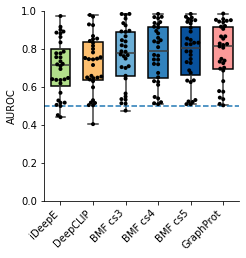

In [11]:
metric_list = auc_list
metric_name = 'AUROC'
combine_reps_boxplot(metric_list, metric_name, thr=0)

# Scatter plots

In [12]:
datasets = ['BMF cs3','BMF cs4','BMF cs5','GraphProt','iDeepE', 'DeepCLIP']
colors = ['#6baed6','#3182bd','#08519c','#fb9a99','#b2df8a','#fdbf6f']

In [13]:
epfactors, epauc, _ = pickle.load(open(os.path.join(plotting_dir,'AUROC_byfactor.pkl'), 'rb' ))
plotting_dir_combined = os.path.join(plotting_dir,'scatter')

In [14]:
def plot_comparison_scatter(xaxis=3, yaxis=0):
    
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    sns.despine()

    for i in range(epauc.shape[0]):
        if (epauc[i,xaxis]/epauc[i,yaxis])>1.1:
            ax.text(epauc[i,xaxis],epauc[i,yaxis]-0.03,epfactors[i], verticalalignment='top',horizontalalignment='center')
        elif (epauc[i,yaxis]/epauc[i,xaxis])>1.1:
            ax.text(epauc[i,xaxis]-0.03,epauc[i,yaxis],epfactors[i], verticalalignment='center',horizontalalignment='right')

    _ = ax.scatter(epauc[:,xaxis],epauc[:,yaxis], linewidths=0.7, edgecolor='black')
    _ = ax.set_xlim(0,1)
    _ = ax.set_ylim(0,1)
    _ = ax.plot([0,1],[0,1],ls='--')
    _ = ax.set_xlabel(f'{datasets[xaxis]} AUROC')
    _ = ax.set_ylabel(f'{datasets[yaxis]} AUROC')
    
    #put wilcoxon p-value
    _ , p = wilcoxon(epauc[:,xaxis],epauc[:,yaxis])
    ax.text(0.5,0.05,f'P-value={p:.4f}')

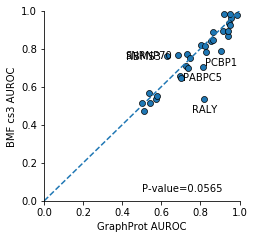

In [15]:
xaxis = 3
yaxis = 0
plot_comparison_scatter(xaxis,yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

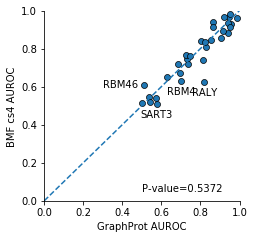

In [16]:
xaxis = 3
yaxis = 1
plot_comparison_scatter(xaxis,yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

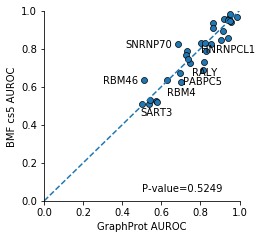

In [17]:
xaxis = 3
yaxis = 2
plot_comparison_scatter(xaxis,yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

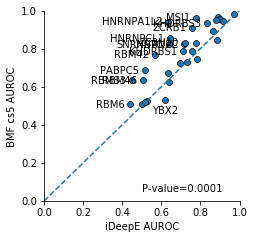

In [18]:
xaxis = 4
yaxis = 2
plot_comparison_scatter(xaxis,yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

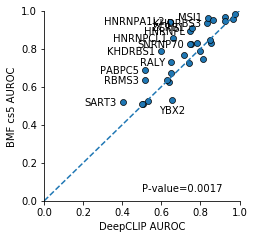

In [19]:
xaxis = 5
yaxis = 2
plot_comparison_scatter(xaxis,yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

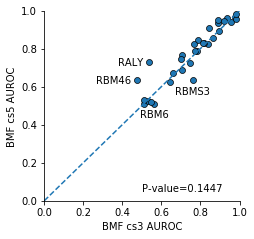

In [20]:
xaxis = 0
yaxis = 2
plot_comparison_scatter(xaxis,yaxis)
plt.savefig(os.path.join(plotting_dir_combined,f'AUC_{xaxis}vs{yaxis}_newbg.pdf'), bbox_inches='tight')

# Relationship between k and performance of BMF

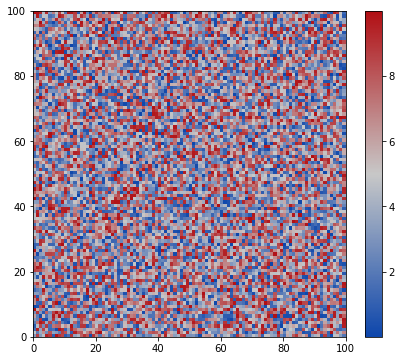

In [21]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

# MAKE CUSTOM COLORMAP
data = np.random.random([100, 100]) * 10

N = 256
grey_value = 200
red = np.ones((N, 4))
#red:178,24,43
#grey:150,150,150
red[:, 0] = np.linspace(178/N, grey_value/N, N) # R = 255
red[:, 1] = np.linspace(15/N, grey_value/N, N) # G = 232
red[:, 2] = np.linspace(20/N, grey_value/N, N)  # B = 11
red_cmap = ListedColormap(red)

blue = np.ones((N, 4))
#blue:33,102,172
#grey:150,150,150
blue[:, 0] = np.linspace(13/N, grey_value/N, N) # R = 255
blue[:, 1] = np.linspace(70/N, grey_value/N, N) # G = 232
blue[:, 2] = np.linspace(172/N, grey_value/N, N)  # B = 11
blue_cmap = ListedColormap(blue)

newcolors2 = np.vstack((blue_cmap(np.linspace(0, 1, 128)),
                       red_cmap(np.linspace(1, 0, 128))))
custom_colormap = ListedColormap(newcolors2, name='double')
plt.figure(figsize=(7, 6))
plt.pcolormesh(data, cmap=custom_colormap)
plt.colorbar()

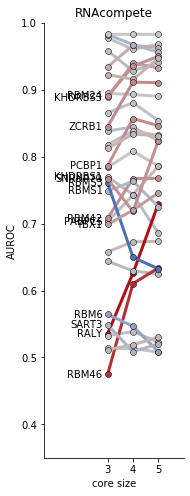

In [22]:
sns.axes_style("white")
fig, ax = plt.subplots(figsize=(2.5,8))
xpos = np.arange(3,6)
#sns.despine(fig=fig,trim=True)

colorsList = ['#b2182b','#bdbdbd', '#2166ac']
cmap = custom_colormap
a = epauc[:,2]-epauc[:,0]
max_range = max(abs(min(a)),abs(max(a)))
a = (a+max_range)/(2*max_range)
colors = [cmap(c) for c in a]

for i, factor in enumerate(epfactors):
    ax.plot(xpos,epauc[i,0:3], 'o-', color=colors[i],lw=3,
            markeredgecolor='black',markeredgewidth=0.5)
    if max(epauc[i,0:3])/min(epauc[i,0:3]) > 1.05:
        ax.text(2.8,epauc[i,0], epfactors[i], horizontalalignment='right', 
                 fontsize=10,
                 verticalalignment='center')

ax.set_xlim(.5,6)
ax.set_ylim(0.35,1)
ax.set_title('RNAcompete')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(xpos)
ax.set_xlabel('core size')
ax.set_ylabel('AUROC')

plt.savefig(os.path.join(plotting_dir_combined,f'AUROC_vs_CS_custom_colormap.pdf'), bbox_inches='tight')